In [45]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#load the data
def load_data(file_path):
    return pd.read_excel(file_path, engine="openpyxl")

#info about the data
def info_about_data (df):
    print(df.info())
    print("\nShape of the data:\n", df.shape)
    print("\nData type:\n", df.dtypes)
    print("\nMissing values:\n", df.isnull().sum())
    print("\nUnique values:\n", df.nunique())
    print("\nDuplicate Rows:\n", df.duplicated().sum())

In [5]:
#fill exit date
def fill_exit_date(df):
    df["Hire Date"] = pd.to_datetime(df["Hire Date"], errors='coerce')
    df["Exit Date"] = pd.to_datetime(df["Exit Date"], errors='coerce')
    df["Age"] = pd.to_numeric(df["Age"], errors='coerce')
    df["Gender"] = df["Gender"].str.strip().str.lower()

    # Define retirement ages
    retirement_ages = {"male": 60, "female": 55}

    # Identify rows where Exit Date is missing
    missing_exit = df["Exit Date"].isna()
    
    # Ensure only rows with valid Age and Gender are updated
    valid_age = df.loc[missing_exit, "Age"].notna()
    valid_gender = df.loc[missing_exit, "Gender"].isin(retirement_ages)

    # Calculate estimated exit date for missing values only
    def calculate_exit_date(row):
        retirement_age = retirement_ages[row["Gender"]]
        return row["Hire Date"] + pd.DateOffset(years=(retirement_age - row["Age"]))

    # Apply filling only where Exit Date was originally missing
    df.loc[missing_exit & valid_age & valid_gender, "Exit Date"] = df.loc[
        missing_exit & valid_age & valid_gender
    ].apply(calculate_exit_date, axis=1)

    return df

#clean the data
def clean_data(df):
    df.drop_duplicates(inplace=True)
    df["Full Name"].fillna("Not Provided", inplace=True)
    df["Country"].fillna("Not Provided", inplace=True)
    df["Gender"].fillna(df["Gender"].mode()[0] if not df["Gender"].mode().empty else "Not Provided", inplace=True)
    df["Job Title"].fillna(df.groupby("Department")["Job Title"].transform(lambda x: x.mode()[0] if not x.mode().empty else "Unknown"), inplace=True)
    df["Department"].fillna(df["Department"].mode()[0] if not df["Department"].mode().empty else "Not Assigned", inplace=True)
     # Fill missing ethnicity based on country
    for x in df.index:
        if pd.isna(df.loc[x, "Ethnicity"]) or str(df.loc[x, "Ethnicity"]).strip() == "":
            if df.loc[x, "Country"] == "China":
                df.loc[x, "Ethnicity"] = "Asian"
            elif df.loc[x, "Country"] == "Brazil":
                df.loc[x, "Ethnicity"] = "Latino"
            else:
                df.loc[x, "Ethnicity"] = "Not Provided"
    df["Age"].fillna(df["Age"].median(), inplace=True)
    df["Annual Salary"].fillna(df.groupby("Job Title")["Annual Salary"].transform(lambda x: x.median()), inplace=True)
    df["Bonus %"].fillna(df["Bonus %"].mean(), inplace=True)
    # Fill missing Hire Date with the earliest recorded date
    earliest_hire_date = df["Hire Date"].min()
    df["Hire Date"].fillna(earliest_hire_date, inplace=True)  
    # Fill missing cities based on country and ethnicity using a loop
    for x in df.index:
        if pd.isna(df.loc[x, "City"]) or str(df.loc[x, "City"]).strip() == "":
            if df.loc[x, "Country"] == "United States" and df.loc[x, "Ethnicity"] == "Caucasian":
                df.loc[x, "City"] = df["City"].mode()[0]
            else:
                df.loc[x, "City"] = "Not Provided"          
    df = fill_exit_date(df)
    return df

In [6]:
#modify the first five rows 
def modify_first_five_rows(df):
    sample_data = [
        ["Alice Johnson", "Software Engineer", "IT", 30, 120000],
        ["Bob Smith", "Data Scientist", "IT", 35, 135000],
        ["Charlie Brown", "Marketing Manager", "Marketing", 40, 95000],
        ["Diana Prince", "HR Specialist", "HR", 32, 85000],
        ["Ethan Hunt", "Sales Executive", "Sales", 45, 110000],
    ] 
    df.loc[:4, ["Full Name", "Job Title", "Department", "Age", "Annual Salary"]] = sample_data
    return df


In [7]:
#analyez for data
def analyze_data(df):
    max_salary = df["Annual Salary"].max()
    highest_salary_row = df[df["Annual Salary"] == max_salary]
    grouped_dept = df.groupby("Department")[["Age", "Annual Salary"]].mean()
    grouped_dept_ethnicity = df.groupby(["Department", "Ethnicity"])[["Age", "Annual Salary"]].agg(["max", "min", "median"])
    return highest_salary_row, grouped_dept, grouped_dept_ethnicity


In [8]:
#save the data in excle file 
def save_data(df,file_path):
    df.to_excel(file_path,index=False)

In [9]:
#the excute for the code 
file_path=r"C:\Users\user\Downloads\Employee Sample Data - A.xlsx"
df=load_data(file_path)
info_about_data(df)
df=clean_data(df)
info_about_data(df)
df=modify_first_five_rows(df)
highest_salary, grouped_dept, grouped_dept_ethnicity = analyze_data(df)
output_path = "Processed_Employee_Data.xlsx"
save_data(df, output_path)
print("Highest Salary Employee:\n", highest_salary)
print("\nAverage Age & Salary per Department:\n", grouped_dept)
print("\nDepartment + Ethnicity Analysis:\n", grouped_dept_ethnicity)
print("\nProcessed data saved to:", output_path)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   EEID           1000 non-null   object        
 1   Full Name      998 non-null    object        
 2   Job Title      999 non-null    object        
 3   Department     998 non-null    object        
 4   Business Unit  1000 non-null   object        
 5   Gender         999 non-null    object        
 6   Ethnicity      993 non-null    object        
 7   Age            994 non-null    float64       
 8   Hire Date      993 non-null    datetime64[ns]
 9   Annual Salary  989 non-null    float64       
 10  Bonus %        992 non-null    float64       
 11  Country        998 non-null    object        
 12  City           998 non-null    object        
 13  Exit Date      85 non-null     datetime64[ns]
dtypes: datetime64[ns](2), float64(3), object(9)
memory usage: 109.5+ KB
None


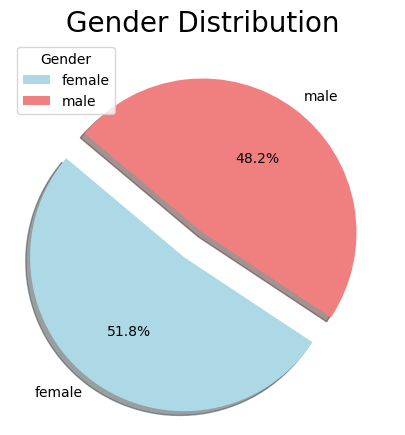

In [24]:
#Gender distribution
# Count gender distribution
gender_counts = df["Gender"].value_counts()

# Define explode values to separate slices
explode_values = [0.2,0.0]  

# Plot pie chart with shadow and explode effect
plt.figure(figsize=(10,5))
plt.pie(gender_counts, labels=gender_counts.index, autopct="%1.1f%%", 
        colors=["lightblue", "lightcoral"], startangle=140, 
        explode=explode_values, shadow=True)
plt.title("Gender Distribution",loc='center',fontsize=20)
plt.legend(title="Gender", loc="upper left")
plt.show()

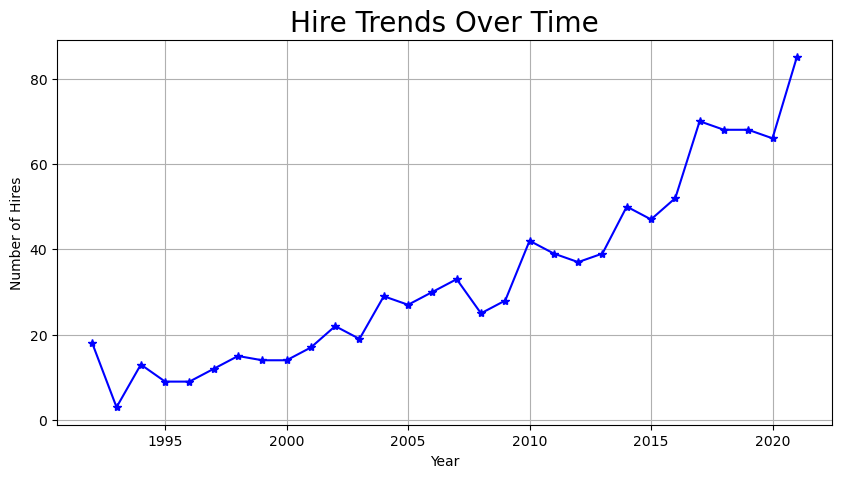

In [23]:
#hire date over the time 
# Ensure Hire Date is in datetime format
df["Hire Date"] = pd.to_datetime(df["Hire Date"], errors="coerce")

# Extract the year from Hire Date
df["Hire Year"] = df["Hire Date"].dt.year

# Count hires per year
hire_trends = df["Hire Year"].value_counts().sort_index()

# Plot the hiring trends
plt.figure(figsize=(10, 5))
plt.plot(hire_trends.index, hire_trends.values, marker="*", linestyle="-", color="blue")

# Customize the plot
plt.xlabel("Year")
plt.ylabel("Number of Hires")
plt.title("Hire Trends Over Time",loc='center',fontsize=20)
plt.grid(True)
# Show the plot
plt.show()

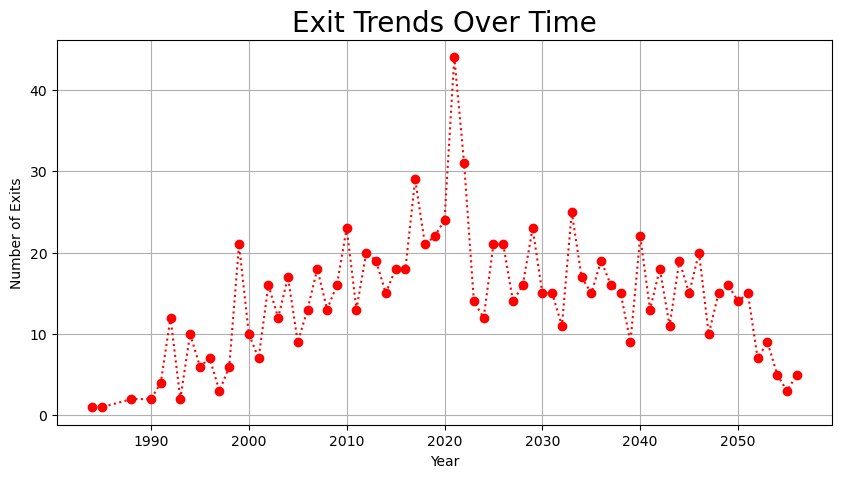

In [25]:
#exit date over the time 
# Ensure Exit Date is in datetime format
df["Exit Date"] = pd.to_datetime(df["Exit Date"], errors="coerce")

# Extract the year from Exit Date
df["Exit Year"] = df["Exit Date"].dt.year

# Count exits per year
exit_trends = df["Exit Year"].value_counts().sort_index()

# Plot the exit trends
plt.figure(figsize=(10, 5))
plt.plot(exit_trends.index, exit_trends.values, marker="o", linestyle=":", color="red")

# Customize the plot
plt.xlabel("Year")
plt.ylabel("Number of Exits")
plt.title("Exit Trends Over Time",loc='center',fontsize=20)
plt.grid(True)
# Show the plot
plt.show()

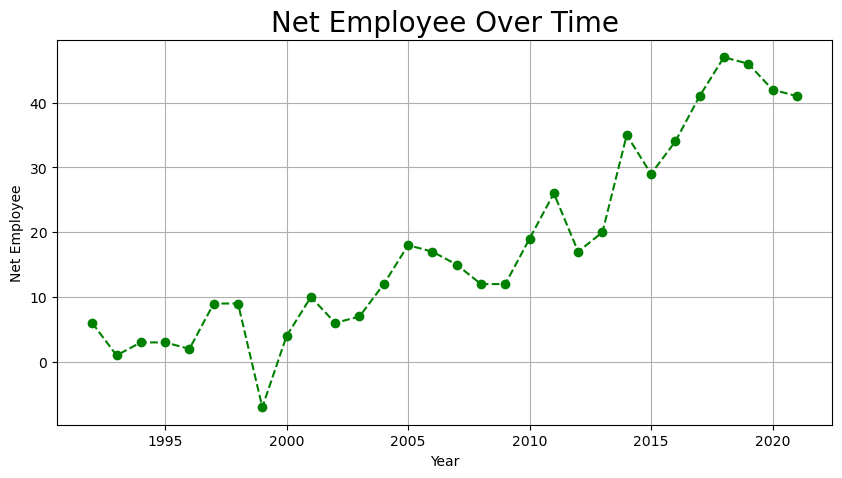

In [26]:
''' the net change ((Hires - Exits) for each year)
    if it positive the company is growing
    if it negative the company is shrinking'''
# Compute Net Employee Change directly
net_employee = hire_trends - exit_trends

# Plot net employee change
plt.figure(figsize=(10,5))
plt.plot(net_employee.index, net_employee.values, marker="o", mec="green", 
         mfc="green", linestyle="--", color="green")

# Customize the plot
plt.grid()
plt.title("Net Employee Over Time",loc='center',fontsize=20)
plt.xlabel("Year")
plt.ylabel("Net Employee")

# Show the plot
plt.show()

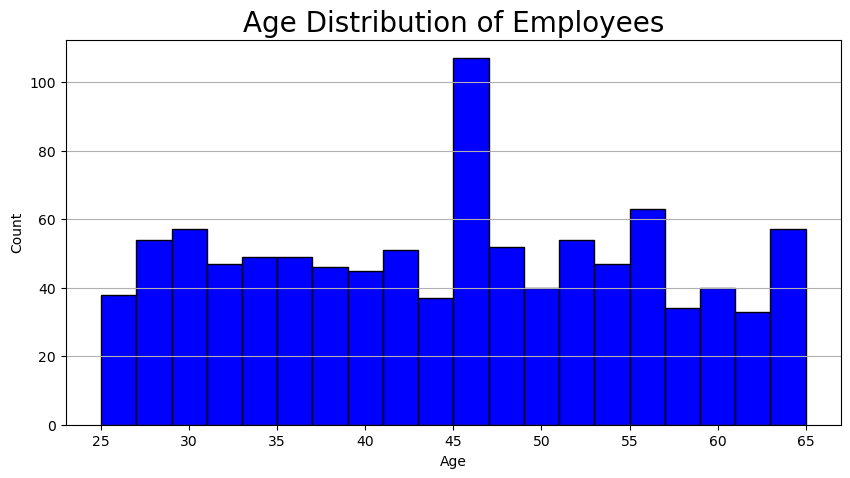

In [32]:
#Age Distribution as a Histogram
plt.figure(figsize=(10, 5))
plt.hist(df["Age"].dropna(),bins=20, color="blue", edgecolor="black")

# Customize the plot
plt.xlabel("Age")
plt.ylabel("Count")
plt.title("Age Distribution of Employees",loc='center',fontsize=20)
plt.grid(axis="y")

# Show the plot
plt.show()

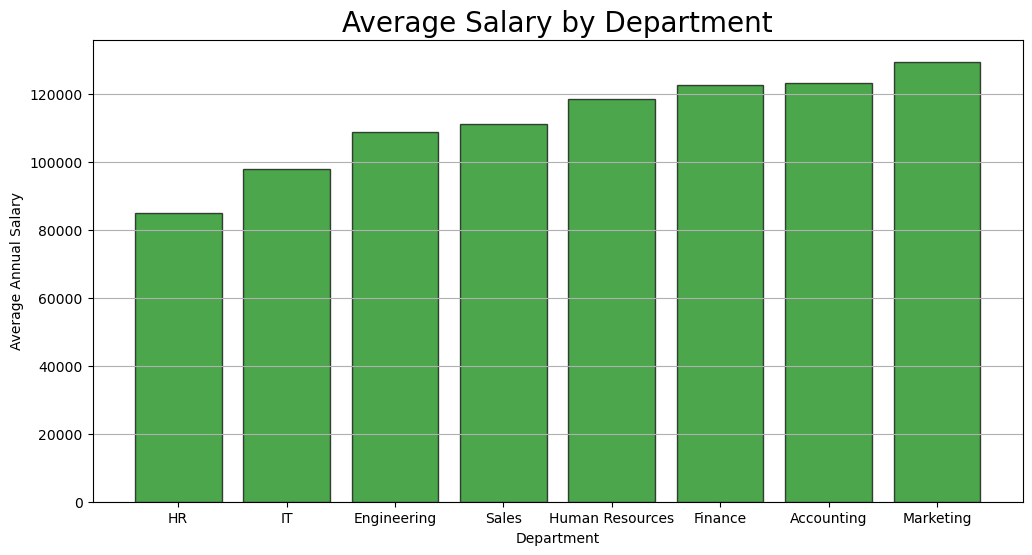

In [35]:
# Group by Department and calculate the average salary
salary_by_dept = df.groupby("Department")["Annual Salary"].mean().sort_values()

# Plot Salary Distribution by Department
plt.figure(figsize=(12, 6))
plt.bar(salary_by_dept.index, salary_by_dept.values, color="green", edgecolor="black", alpha=0.7)

# Customize the plot
plt.xlabel("Department")
plt.ylabel("Average Annual Salary")
plt.title("Average Salary by Department",loc='center',fontsize=20)
plt.grid(axis="y")

# Show the plot
plt.show()

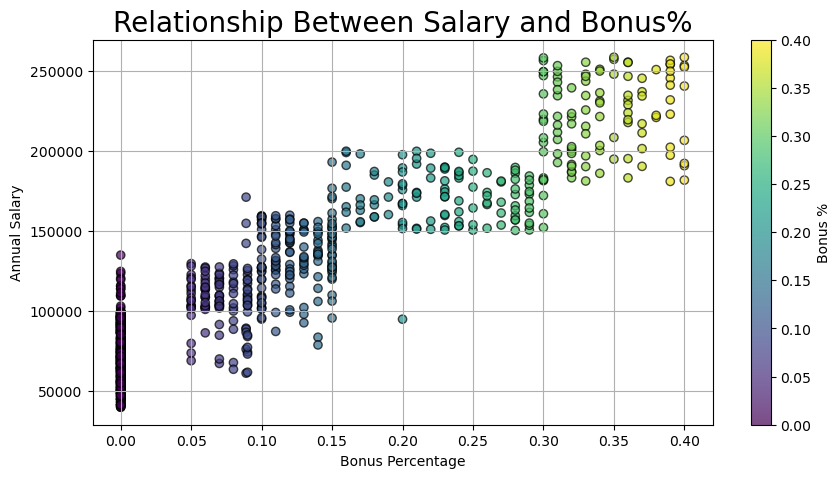

In [40]:
# Scatter plot for Salary vs Bonus%
plt.figure(figsize=(10, 5))
plt.scatter( df["Bonus %"],df["Annual Salary"],c=df['Bonus %'], cmap='viridis', alpha=0.7, edgecolors="black")
plt.colorbar(label='Bonus %')
# Customize the plot
plt.ylabel("Annual Salary")
plt.xlabel("Bonus Percentage")
plt.title("Relationship Between Salary and Bonus%",loc='center',fontsize=20)
plt.grid()

# Show the plot
plt.show()


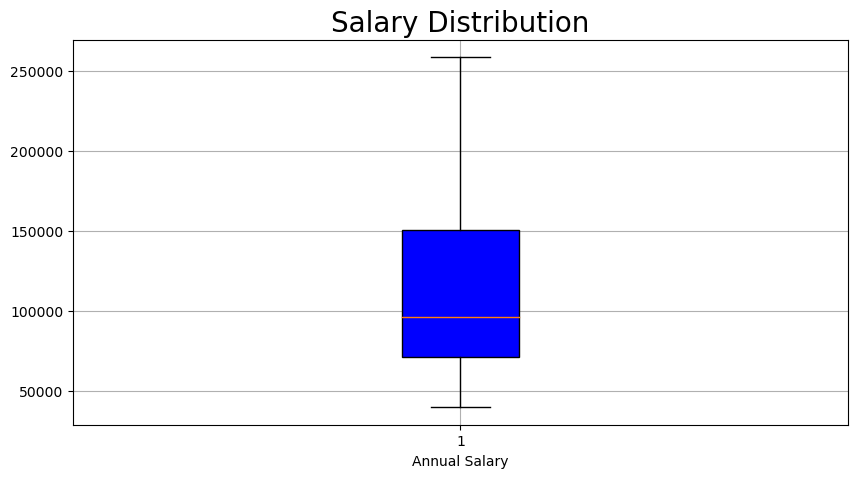

In [44]:
#salary distbution
plt.figure(figsize=(10,5))
plt.boxplot(df["Annual Salary"].dropna(), patch_artist=True,boxprops=dict(facecolor='blue'))
plt.xlabel("Annual Salary")
plt.title("Salary Distribution",loc='center',fontsize=20)
plt.grid()
plt.show()


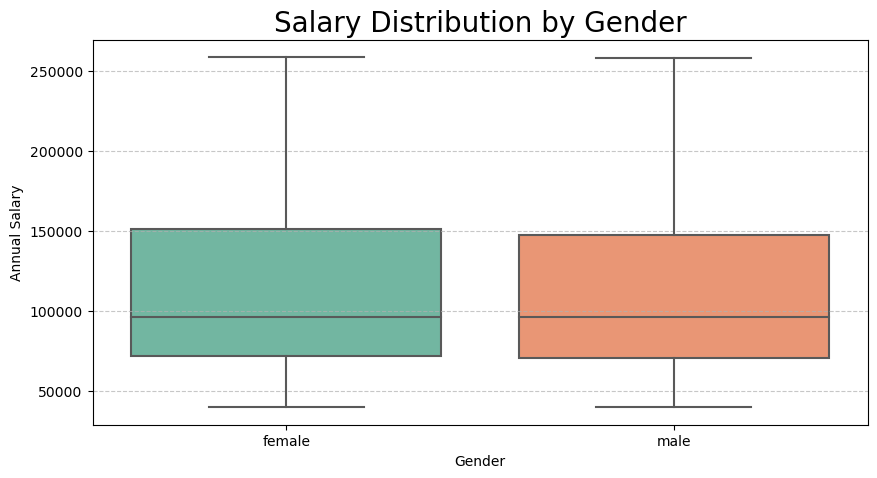

In [50]:
#Gender-Based Salary Comparison
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["Gender"], y=df["Annual Salary"], palette="Set2")
plt.xlabel("Gender")
plt.ylabel("Annual Salary")
plt.title("Salary Distribution by Gender", loc='center', fontsize=20)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

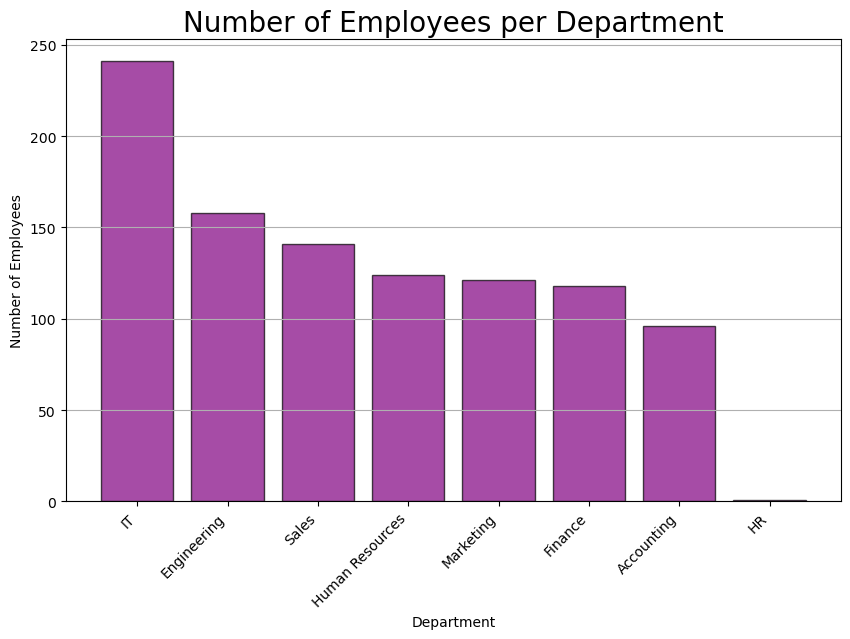

In [ ]:
#Department Employee Count
dept_counts = df["Department"].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(dept_counts.index, dept_counts.values, color="purple", edgecolor="black", alpha=0.7)
plt.xlabel("Department")
plt.ylabel("Number of Employees")
plt.title("Number of Employees per Department",loc='center',fontsize=20)
plt.grid(axis="y")
plt.show()

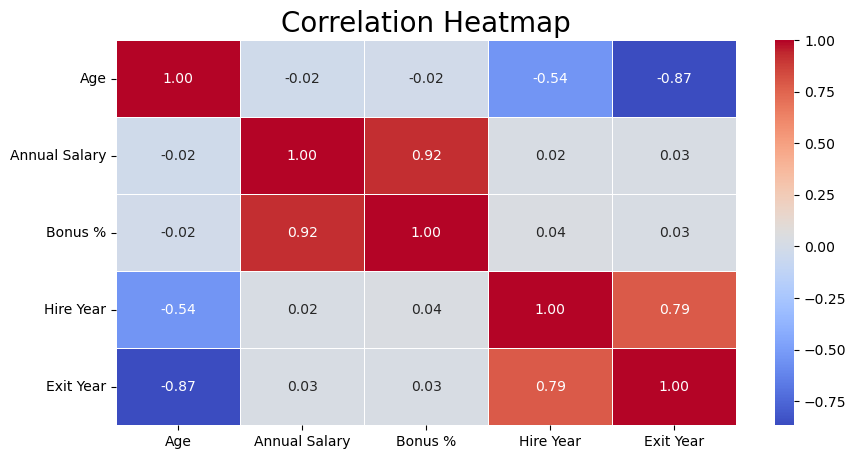

In [51]:
#heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap",loc='center',fontsize=20)
plt.show()